# LRC

Example taken from: https://cmps-people.ok.ubc.ca/jbobowsk/Python/html/Jupyter%20ODEs.html

### Model

$$ \begin{cases} q' = z_1 \\
                 q'' = V_0 / L - (R/L)*z_1 - z_0/(LC) \end{cases} $$

True parameter values: $L = 20e-3, R = 1e3, C=1e-9, V_0 = 1$

Initial conditions: $z_0 = 0, z_1 = 0$

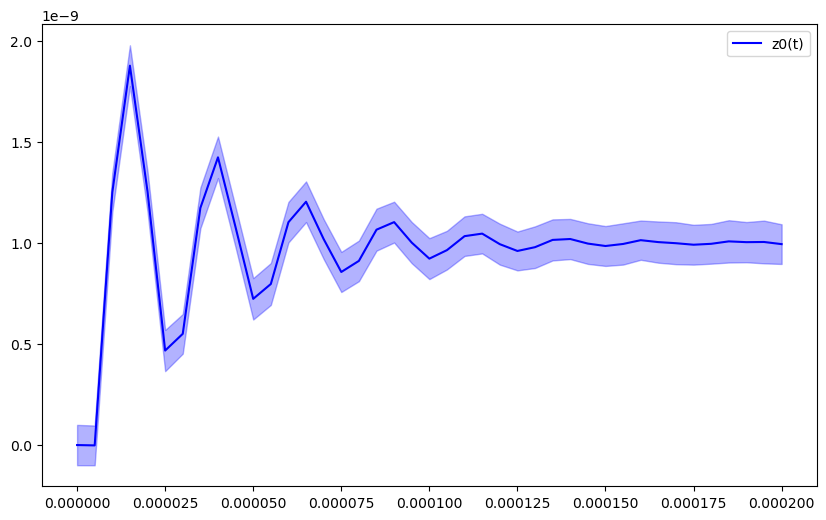

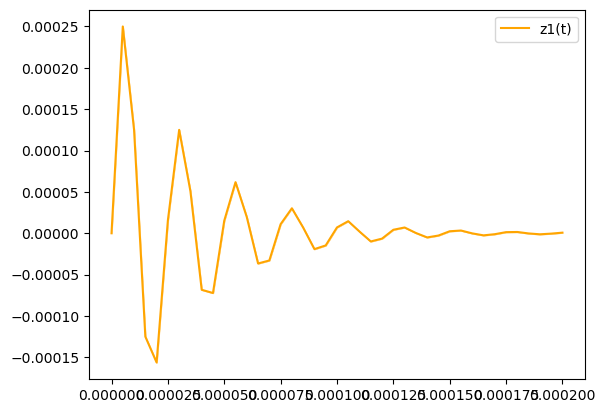

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

V0=1
L=20e-3
R=1e3
C=1e-9

def q_derivatives(z00, z10, T, V0, R, L, C, dt):
    t = [0.]
    z0 = [z00]
    z1 = [z10]

    while(t[-1] < T):
        z0t = z0[-1] + dt*z1[-1]
        z1t = z1[-1] + dt * ((V0/L) - (R/L)*z1[-1] - z0t/(L*C))
        z0.append(z0t)
        z1.append(z1t)
        t.append(t[-1] + dt)

    return t, z0, z1


def LRC_noisy(z00, z10, T, V0, R, L, C, dt, n_rep, sigma = 1e-13):

    len_T = int(T/dt) + 1

    z0_samples = np.zeros((n_rep, len_T))
    z1_samples = np.zeros((n_rep, len_T))

    for i in range(n_rep):
        t, z0, z1 =  q_derivatives(z00, z10, T, V0, R, L, C, dt)
        z0 = np.array(z0) + np.random.normal(0, sigma, len(z0))
        z1 = np.array(z1) + np.random.normal(0, sigma, len(z1))
        z0_samples[i] = z0
        z1_samples[i] = z1

    return t, z0_samples, z1_samples

'''
def bayesian_lotka_volterra(x0, y0, T, alpha, beta, dt, n_rep, sigma = 0.01):

    len_T = int(T/dt) + 1

    x_samples = np.zeros((n_rep, len_T))
    y_samples = np.zeros((n_rep, len_T))

    for i in range(n_rep):
        alpha_sampled = np.random.normal(alpha, sigma)
        beta_sampled = np.random.normal(beta, sigma)
        t, x, y = lotka_volterra(x0, y0, T, alpha_sampled, beta_sampled, dt)
        x_samples[i] = x
        y_samples[i] = y

    return t, x_samples, y_samples
'''

t_samples, z0_samples, z1_samples = LRC_noisy(0., 0., T =0.2e-3 ,V0=1, L=20e-3, R=1e3, C=1e-9, dt=5e-06, n_rep=1000, sigma=1e-10)

mean_z0 = np.mean(z0_samples, axis=0)
std_z0 = np.std(z0_samples, axis=0)

mean_z1 = np.mean(z1_samples, axis=0)
std_z1 = np.std(z1_samples, axis=0)

# Plotting x(t) with uncertainty
plt.figure(figsize=(10, 6))
plt.plot(t_samples, mean_z0, label='z0(t)', color='blue')
plt.fill_between(t_samples, mean_z0 - std_z0, mean_z0 + std_z0, color='blue', alpha=0.3)
plt.legend()
plt.show()

# Plotting y(t) with uncertainty
plt.plot(t_samples, mean_z1, label='z1(t)', color='orange')
plt.fill_between(t_samples, mean_z1 - std_z1, mean_z1 + std_z1, color='orange', alpha=0.3)

plt.legend()
plt.show()



In [32]:
0.2e-3/40

5e-06

### Parameter estimation in SOGA 

In [24]:
from sogaPreprocessor import *
from producecfg import *
from libSOGAsmoother import *
from time import time

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

In [40]:
def extract_mean_and_std(output_dist, len):

    x_soga = [0.]
    y_soga = [0.]
    x_soga_std = [0.]
    y_soga_std = [0.]

    for i in range(len):
        x_idx = output_dist.var_list.index('z0[{}]'.format(i))
        y_idx = output_dist.var_list.index('z1[{}]'.format(i))
        x_soga.append(output_dist.gm.mean()[x_idx].item())
        y_soga.append(output_dist.gm.mean()[y_idx].item())
        x_soga_std.append(np.sqrt(output_dist.gm.cov()[x_idx][x_idx].item()))
        y_soga_std.append(np.sqrt(output_dist.gm.cov()[y_idx][y_idx].item()))

    return x_soga, y_soga, x_soga_std, y_soga_std

def plot_mean_and_std(x, y, x_std, y_std, label_x, label_y):
    
    t = np.linspace(0, 3, len(x))

    plt.plot(t, x, label=label_x, color='blue')
    plt.fill_between(t, np.array(x) - np.array(x_std), np.array(x) + np.array(x_std), color='blue', alpha=0.3)
    plt.show()
    plt.plot(t, y, label=label_y, color='orange')
    plt.fill_between(t, np.array(y) - np.array(y_std), np.array(y) + np.array(y_std), color='orange', alpha=0.3)
    plt.show()


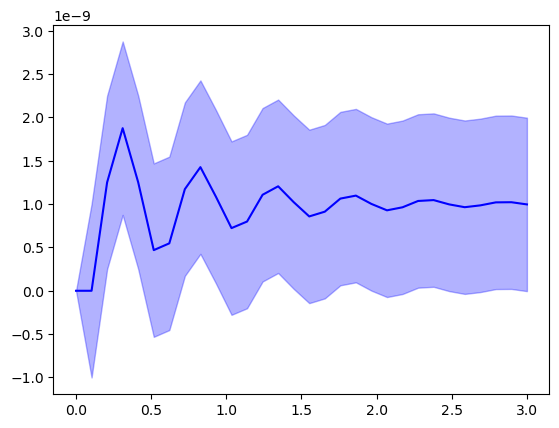

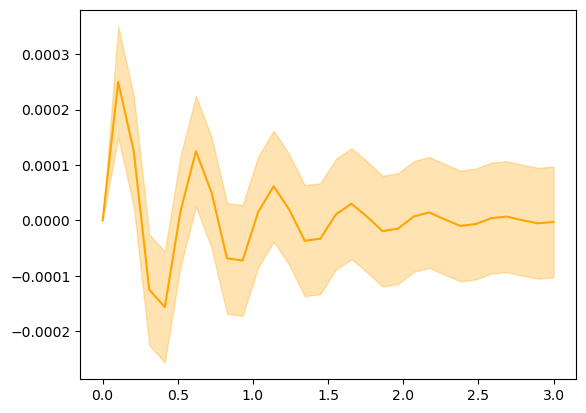

In [50]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/LRC.soga')
cfg = produce_cfg(compiledFile)

pars = {'VL':V0/L, 'RL':R/L, 'LC': 1/(L*C)}  # starting from wrong parameters

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)
x_soga, y_soga, x_soga_std, y_soga_std = extract_mean_and_std(output_dist, len=29)
plot_mean_and_std(x_soga, y_soga, x_soga_std, y_soga_std, 'x(t) initial', 'y(t) initial')

In [51]:
# Preparing trajectories data

n_traj = 50

x_traj_idx = []
y_traj_idx = []

for i in range(1,30):
    x_traj_idx.append(output_dist.var_list.index('z0[{}]'.format(i)))
    y_traj_idx.append(output_dist.var_list.index('z1[{}]'.format(i)))

x_traj = torch.tensor(z0_samples[:n_traj, :29])
y_traj = torch.tensor(z1_samples[:n_traj, :29])

# loss

def neg_log_likelihood(x_traj, y_traj, dist):
    log_likelihood = torch.log(dist.gm.marg_pdf(x_traj, x_traj_idx)) + torch.log(dist.gm.marg_pdf(y_traj, y_traj_idx))
    return - torch.sum(log_likelihood)

neg_log_likelihood(x_traj, y_traj, output_dist)

tensor(-39388.3724, grad_fn=<NegBackward0>)

In [52]:
pars = {'VL':V0/L, 'RL':R/L, 'LC': 1/(L*C)}
print(pars)

{'VL': 50.0, 'RL': 50000.0, 'LC': 49999999999.99999}


In [57]:
# Define the optimizer with init_mean as the parameter
pars = {'VL':30., 'RL':1000., 'LC': 1/(L*C)}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=10)

total_start = time()

for i in range(5000):

    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)

    loss = neg_log_likelihood(x_traj, y_traj, current_dist)

    # Backpropagate
    loss.backward()
    
    optimizer.step()

    
    # Print progress
    if i % 10 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))


VL: 20.00000000147422 RL: 1009.9999984668159 LC: 49999999991.02218  loss: -38893.59696116447
VL: 11.199037789396854 RL: 1060.9820343073231 LC: 49999999948.78255  loss: -39661.90938881876
VL: 2.884563022975303 RL: 1101.4835846428764 LC: 49999999895.84495  loss: -39647.1497508556
VL: 10.689323543025631 RL: 1124.248313545435 LC: 49999999846.13572  loss: -39646.74883222268
VL: 6.019753713254078 RL: 1145.769155367219 LC: 49999999786.830124  loss: -39656.918415261986
VL: 7.020454477189742 RL: 1161.250607353685 LC: 49999999727.77397  loss: -39662.42352886369
VL: 8.122503729090687 RL: 1175.3245981762864 LC: 49999999667.03891  loss: -39661.778998038775
VL: 7.306933287657898 RL: 1190.109076317308 LC: 49999999604.28997  loss: -39662.381546307115
VL: 7.128078181859349 RL: 1205.0202565409502 LC: 49999999540.83303  loss: -39662.44290769636
VL: 7.39425904713051 RL: 1220.4042323022204 LC: 49999999476.76528  loss: -39662.52803791777
VL: 7.491798801371854 RL: 1236.6237515465705 LC: 49999999412.00267  lo

In [58]:
for elem in params_dict:
    opt_pars = {elem: torch.tensor(params_dict[elem].item()) for elem in params_dict}

opt_pars

{'VL': tensor(18.8329), 'RL': tensor(44587.2568), 'LC': tensor(5.0000e+10)}

In [60]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/LRC.soga')
cfg = produce_cfg(compiledFile)
output_dist = start_SOGA(cfg, params_dict = opt_pars)

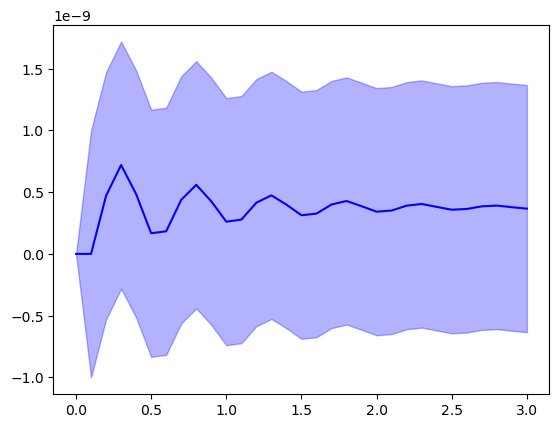

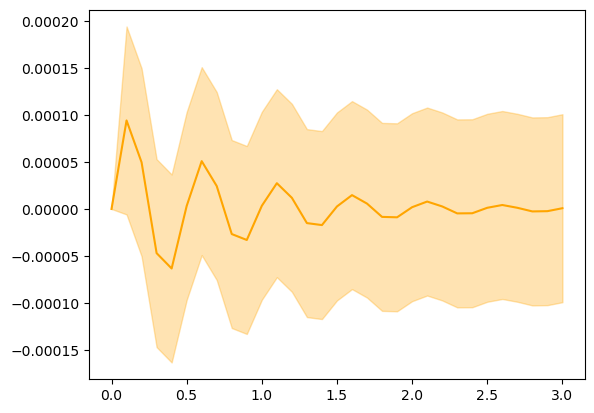

In [61]:
x_opt, y_opt, x_opt_std, y_opt_std = extract_mean_and_std(output_dist, len=30)

plot_mean_and_std(x_opt, y_opt, x_opt_std, y_opt_std, 'x(t) optimized', 'y(t) optimized')
#plot_mean_and_std(x_soga, y_soga, x_soga_std, y_soga_std, 'x(t) initial', 'y(t) initial')
#plt.plot(t_samples, mean_x, label='x(t) true', color='blue', linestyle='dashed')
#plt.plot(t_samples, mean_y, label='y(t) true', color='orange', linestyle='dashed')
#plt.legend()

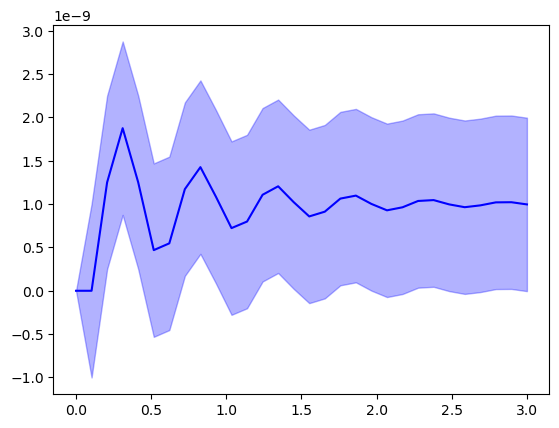

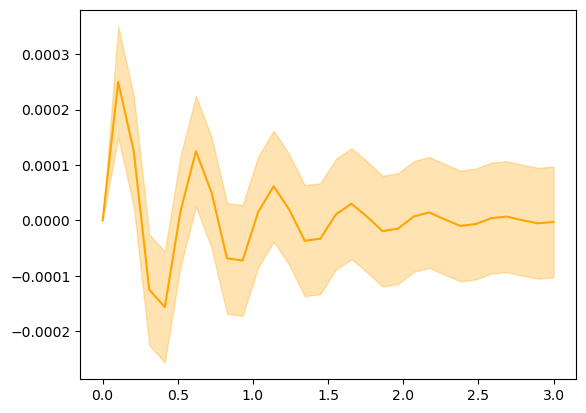

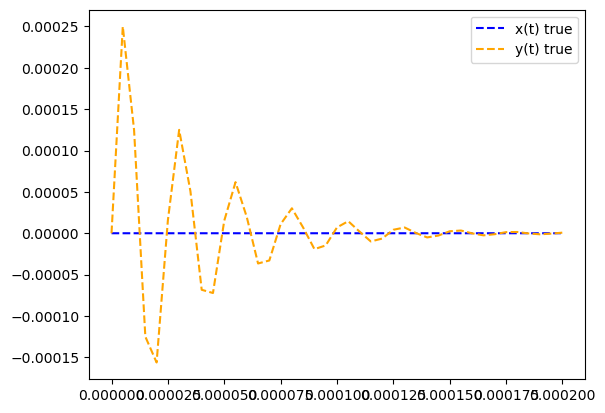

In [62]:
#plot_mean_and_std(x_opt, y_opt, x_opt_std, y_opt_std, 'x(t) optimized', 'y(t) optimized')
plot_mean_and_std(x_soga, y_soga, x_soga_std, y_soga_std, 'x(t) initial', 'y(t) initial')
plt.plot(t_samples, mean_z0, label='x(t) true', color='blue', linestyle='dashed')
plt.plot(t_samples, mean_z1, label='y(t) true', color='orange', linestyle='dashed')

plt.legend()